# MP5: Training Your Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Visualization helper function

In [39]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    num_images, num_columns = images.shape[0], len(column_names)
    assert num_images % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = num_images // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [40]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down(x)
        x = self.conv_block(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up(x)
        x = self.conv_block(x)
        return x

## Implementing Unconditional UNet

In [41]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens // 2)
        self.down2 = DownBlock(num_hiddens // 2, num_hiddens // 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens // 4)

        self.up1 = UpBlock(num_hiddens // 4, num_hiddens // 2)
        self.up2 = UpBlock(num_hiddens, num_hiddens)
        self.out_conv = nn.Conv2d(num_hiddens * 2, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)
        x6 = self.up1(x5)
        x6 = torch.cat([x6, x2], dim=1)

        x7 = self.up2(x6)
        x7 = torch.cat([x7, x1], dim=1)

        out = self.out_conv(x7)
        return out

## Visualizing the noising process

In [85]:
dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
def visualize_noising_process():

    indices = [0, 1, 2, 3, 4]
    images = [dataset[i][0] for i in indices]
    images = torch.stack(images)

    noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

    all_images = []
    column_names = []

    for sigma in noise_levels:
        column_names.append(f"σ={sigma}")

    for i in range(images.shape[0]):
        row_images = []

        torch.manual_seed(i)

        for sigma in noise_levels:

            epsilon = torch.randn_like(images[i:i+1])

            noisy_image = images[i:i+1] + sigma * epsilon * 1.5


            row_images.append(noisy_image)
        all_images.append(torch.cat(row_images, dim=0))
    all_images = torch.cat(all_images, dim=0)

    visualize_images_with_titles(all_images, column_names)

    return all_images, column_names
# TODO

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

In [86]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# TODO
def train_unconditional_unet():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 5
    sigma = 0.5

    train_losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            epsilon = torch.randn_like(data)
            noisy_data = data + sigma * epsilon

            optimizer.zero_grad()
            output = model(noisy_data)

            loss = F.mse_loss(output, data)

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            train_losses.append(loss.item())

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.6f}")

        print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {sum(epoch_losses) / len(epoch_losses):.6f}")


        if epoch == 0 or epoch == num_epochs - 1:
            visualize_denoising_results(model, epoch+1, device, sigma)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.yscale('log')
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model, train_losses

def visualize_denoising_results(model, epoch, device, sigma=0.5):

    test_dataset = MNIST(root='data', download=True, transform=ToTensor(), train=False)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

    images, _ = next(iter(test_loader))
    images = images.to(device)

    epsilon = torch.randn_like(images)
    noisy_images = images + sigma * epsilon

    model.eval()
    with torch.no_grad():
        denoised_images = model(noisy_images)


    rows = images.shape[0]
    columns = 3
    column_names = ['Input', f'Noisy (σ={sigma})', 'Output']

    display_images = []
    for i in range(rows):

        display_images.append(images[i:i+1])
        display_images.append(noisy_images[i:i+1])
        display_images.append(denoised_images[i:i+1])

    display_images = torch.cat(display_images, dim=0)
    visualize_images_with_titles(display_images.cpu(), column_names)

    model.train()


...


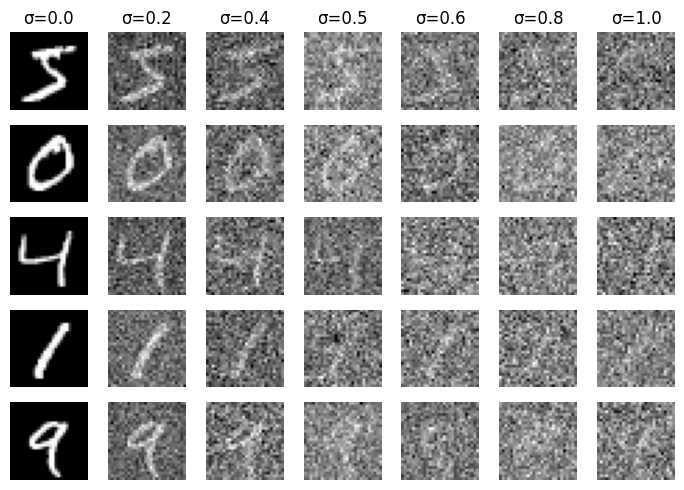

In [87]:
print("...")
all_images, column_names = visualize_noising_process()


training unconditional UNet model...
Epoch 1/5, Batch 0/469, Loss: 0.241604
Epoch 1/5, Batch 100/469, Loss: 0.019294
Epoch 1/5, Batch 200/469, Loss: 0.015796
Epoch 1/5, Batch 300/469, Loss: 0.014461
Epoch 1/5, Batch 400/469, Loss: 0.012774
Epoch 1/5 completed. Average Loss: 0.019975


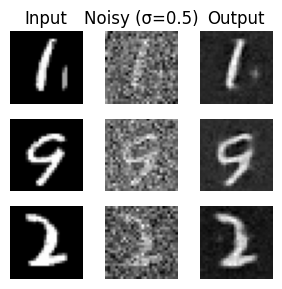

Epoch 2/5, Batch 0/469, Loss: 0.012638
Epoch 2/5, Batch 100/469, Loss: 0.012244
Epoch 2/5, Batch 200/469, Loss: 0.011493
Epoch 2/5, Batch 300/469, Loss: 0.010548
Epoch 2/5, Batch 400/469, Loss: 0.010395
Epoch 2/5 completed. Average Loss: 0.011181
Epoch 3/5, Batch 0/469, Loss: 0.010853
Epoch 3/5, Batch 100/469, Loss: 0.009659
Epoch 3/5, Batch 200/469, Loss: 0.009437
Epoch 3/5, Batch 300/469, Loss: 0.009299
Epoch 3/5, Batch 400/469, Loss: 0.009217
Epoch 3/5 completed. Average Loss: 0.009802
Epoch 4/5, Batch 0/469, Loss: 0.009236
Epoch 4/5, Batch 100/469, Loss: 0.009265
Epoch 4/5, Batch 200/469, Loss: 0.009353
Epoch 4/5, Batch 300/469, Loss: 0.008913
Epoch 4/5, Batch 400/469, Loss: 0.009481
Epoch 4/5 completed. Average Loss: 0.009194
Epoch 5/5, Batch 0/469, Loss: 0.008724
Epoch 5/5, Batch 100/469, Loss: 0.009170
Epoch 5/5, Batch 200/469, Loss: 0.009257
Epoch 5/5, Batch 300/469, Loss: 0.008560
Epoch 5/5, Batch 400/469, Loss: 0.008242
Epoch 5/5 completed. Average Loss: 0.008843


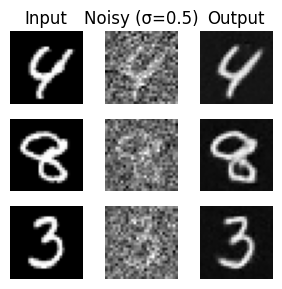

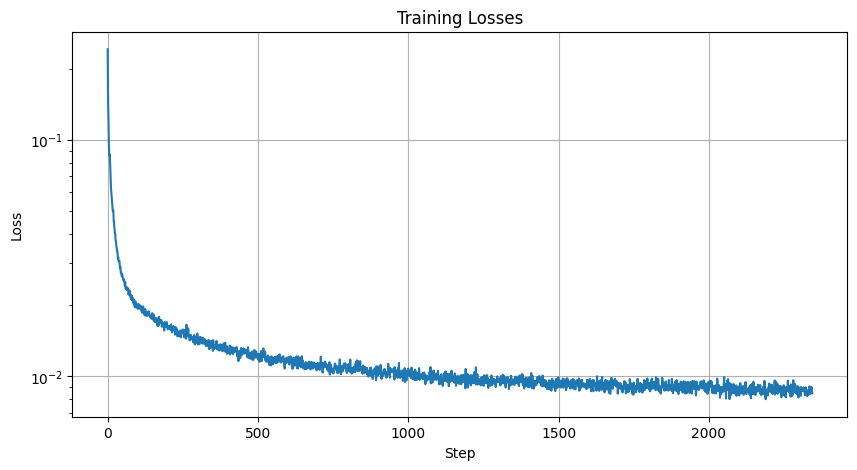

In [60]:

print("training unconditional UNet model...")
trained_model, losses = train_unconditional_unet()

## Out-of-Distribution Testing

In [37]:
# TODO
def test_out_of_distribution(model, device):

    test_dataset = MNIST(root='data', download=True, transform=ToTensor(), train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    image, _ = next(iter(test_loader))
    image = image.to(device)

    noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

    noisy_images = []
    denoised_images = []

    model.eval()
    with torch.no_grad():
        for sigma in noise_levels:
            epsilon = torch.randn_like(image)
            noisy_image = image + sigma * epsilon

            denoised_image = model(noisy_image)

            noisy_images.append(noisy_image)
            denoised_images.append(denoised_image)

    column_names = [f"Noisy Image with σ={sigma}" for sigma in noise_levels]

    plt.figure(figsize=(15, 3))
    for i, img in enumerate(noisy_images):
        plt.subplot(1, len(noise_levels), i+1)
        plt.imshow(img[0, 0].cpu().numpy(), cmap='gray')
        plt.title(column_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 3))
    for i, img in enumerate(denoised_images):
        plt.subplot(1, len(noise_levels), i+1)
        plt.imshow(img[0, 0].cpu().numpy(), cmap='gray')
        plt.title("Denoised Output")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    all_noisy = torch.cat(noisy_images, dim=0)
    all_denoised = torch.cat(denoised_images, dim=0)
    combined = torch.cat([all_noisy, all_denoised], dim=0)
    combined_titles = ["Noisy Image"] * len(noise_levels) + ["Denoised Output"] * len(noise_levels)


    model.train()


 outof distribution testing...


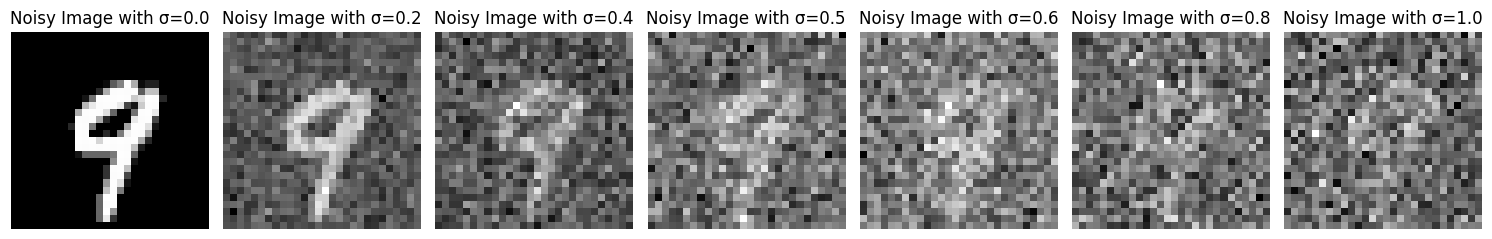

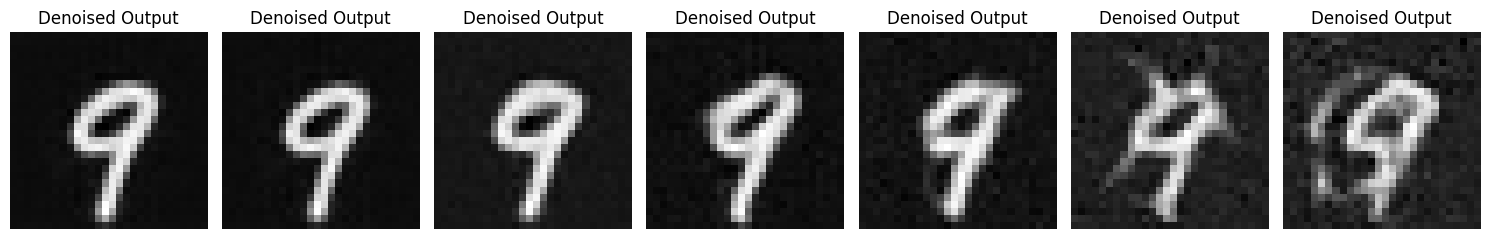

In [57]:
print("\n outof distribution testing...")
test_out_of_distribution(trained_model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [10]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens // 2)
        self.down2 = DownBlock(num_hiddens // 2, num_hiddens // 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens // 4)
        self.fc1_t = FCBlock(1, num_hiddens // 4)
        self.fc2_t = FCBlock(1, num_hiddens // 2)

        self.up1 = UpBlock(num_hiddens // 4, num_hiddens // 4)

        self.conv_adjust = ConvBlock(3 * num_hiddens // 4, num_hiddens // 2)

        self.up2 = UpBlock(num_hiddens // 2, num_hiddens // 2)
        self.out_conv = nn.Conv2d(3 * num_hiddens // 2, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:

        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = t.view(-1, 1)

        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.flatten(x3)
        t1 = self.fc1_t(t)
        t2 = self.fc2_t(t)

        t1 = t1.view(-1, t1.size(1), 1, 1)
        t2 = t2.view(-1, t2.size(1), 1, 1)

        x5 = self.unflatten(x4)
        x5 = x5 + t1

        x6 = self.up1(x5)
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.conv_adjust(x6)

        x7 = self.up2(x6)
        x7 = x7 + t2
        x7 = torch.cat([x7, x1], dim=1)

        out = self.out_conv(x7)
        return out

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [50]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts)

    alphas = 1.0 - betas

    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "betas": nn.Parameter(betas, requires_grad=False),
        "alphas": nn.Parameter(alphas, requires_grad=False),
        "alpha_bars": nn.Parameter(alpha_bars, requires_grad=False)
    }

In [51]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    device = x_0.device
    batch_size = x_0.shape[0]
    t = torch.randint(1, num_ts + 1, (batch_size,), device=device)
    epsilon = torch.randn_like(x_0)
    alpha_bars = ddpm_schedule["alpha_bars"]
    alpha_bars_t = alpha_bars[t - 1].view(-1, 1, 1, 1)

    x_t = torch.sqrt(alpha_bars_t) * x_0 + torch.sqrt(1 - alpha_bars_t) * epsilon

    t_norm = (t - 1) / (num_ts - 1)
    epsilon_pred = unet(x_t, t_norm)
    loss = F.mse_loss(epsilon_pred, epsilon)

    return loss

In [52]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
    num_samples: int = 50,
    fixed_order: list = None,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.
        num_samples: int, number of samples to generate
        fixed_order: list, if provided, generate digits in this specific order

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()

    torch.manual_seed(seed)
    device = next(unet.parameters()).device

    samples_per_digit = num_samples // 10
    num_samples = samples_per_digit * 10

    if fixed_order is None:
        rng = torch.Generator().manual_seed(42)
        all_digits = torch.randperm(10, generator=rng).repeat(samples_per_digit)
        fixed_order = all_digits.tolist()

    all_samples = []

    for i in range(num_samples):
        digit = fixed_order[i]

        x_t = torch.randn(1, 1, img_wh[0], img_wh[1], device=device)

        betas = ddpm_schedule["betas"]
        alphas = ddpm_schedule["alphas"]
        alpha_bars = ddpm_schedule["alpha_bars"]

        position_seed = 1000 + i
        torch.manual_seed(position_seed)

        for t in range(num_ts, 0, -1):
            t_norm = torch.ones(1, device=device) * (t - 1) / (num_ts - 1)

            epsilon_pred = unet(x_t, t_norm)

            z = torch.zeros_like(x_t)
            if t > 1:
                z = torch.randn_like(x_t)

            alpha_t = alphas[t - 1]
            alpha_bar_t = alpha_bars[t - 1]
            alpha_bar_prev = alpha_bars[t - 2] if t > 1 else torch.tensor(1.0, device=device)
            beta_t = betas[t - 1]

            eps_coef = beta_t / torch.sqrt(1 - alpha_bar_t)
            mean_coef1 = 1 / torch.sqrt(alpha_t)

            mu_theta = mean_coef1 * (x_t - eps_coef * epsilon_pred)

            sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))

            x_t = mu_theta + sigma_t * z

        all_samples.append(x_t)

    all_samples = torch.cat(all_samples, dim=0)

    return all_samples, fixed_order

In [54]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
        num_samples: int = 50,
        fixed_order: list = None,
    ):
        return ddpm_sample(
            self.unet,
            self.ddpm_schedule,
            img_wh,
            self.num_ts,
            seed,
            num_samples,
            fixed_order
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [55]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO
def train_time_conditioned_unet():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

    ddpm = DDPM(model, betas=(1e-4, 0.02), num_ts=300).to(device)

    optimizer = optim.Adam(ddpm.parameters(), lr=1e-3)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1.0/20))
    num_epochs = 20
    train_losses = []

    fixed_digit_order = None

    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()
            loss = ddpm(data)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            train_losses.append(loss.item())

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.6f}")

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {sum(epoch_losses) / len(epoch_losses):.6f}")

        if (epoch + 1) % 5 == 0 or epoch == 0:
            with torch.no_grad():

                samples, digit_order = ddpm.sample(
                    img_wh=(28, 28),
                    seed=epoch,
                    num_samples=50,
                    fixed_order=fixed_digit_order
                )

                if fixed_digit_order is None:
                    fixed_digit_order = digit_order

                fig, axes = plt.subplots(5, 10, figsize=(15, 8))
                axes = axes.flatten()

                for i in range(min(50, samples.shape[0])):
                    ax = axes[i]
                    ax.imshow(samples[i, 0].cpu().numpy(), cmap='gray')
                    ax.axis('off')

                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.yscale('log')
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return ddpm, train_losses

Epoch 1/20, Batch 0/469, Loss: 1.284464
Epoch 1/20, Batch 100/469, Loss: 0.123922
Epoch 1/20, Batch 200/469, Loss: 0.086524
Epoch 1/20, Batch 300/469, Loss: 0.081788
Epoch 1/20, Batch 400/469, Loss: 0.068493
Epoch 1/20 completed. Average Loss: 0.100543


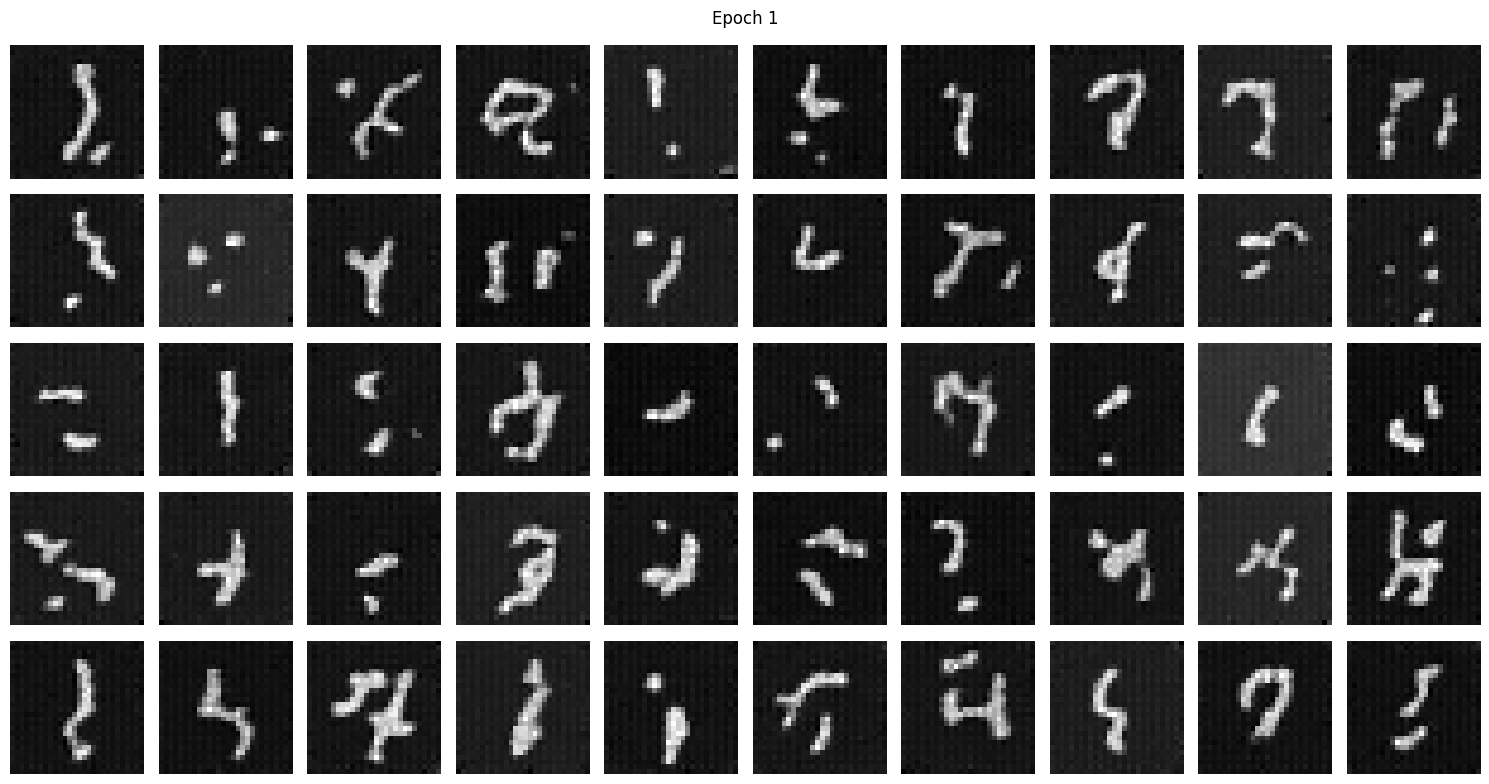

Epoch 2/20, Batch 0/469, Loss: 0.067001
Epoch 2/20, Batch 100/469, Loss: 0.049539
Epoch 2/20, Batch 200/469, Loss: 0.053406
Epoch 2/20, Batch 300/469, Loss: 0.049222
Epoch 2/20, Batch 400/469, Loss: 0.047293
Epoch 2/20 completed. Average Loss: 0.052273
Epoch 3/20, Batch 0/469, Loss: 0.051646
Epoch 3/20, Batch 100/469, Loss: 0.041078
Epoch 3/20, Batch 200/469, Loss: 0.047451
Epoch 3/20, Batch 300/469, Loss: 0.052368
Epoch 3/20, Batch 400/469, Loss: 0.040270
Epoch 3/20 completed. Average Loss: 0.046381
Epoch 4/20, Batch 0/469, Loss: 0.046542
Epoch 4/20, Batch 100/469, Loss: 0.042659
Epoch 4/20, Batch 200/469, Loss: 0.035932
Epoch 4/20, Batch 300/469, Loss: 0.036621
Epoch 4/20, Batch 400/469, Loss: 0.041556
Epoch 4/20 completed. Average Loss: 0.042336
Epoch 5/20, Batch 0/469, Loss: 0.040804
Epoch 5/20, Batch 100/469, Loss: 0.039745
Epoch 5/20, Batch 200/469, Loss: 0.038590
Epoch 5/20, Batch 300/469, Loss: 0.040730
Epoch 5/20, Batch 400/469, Loss: 0.043475
Epoch 5/20 completed. Average Los

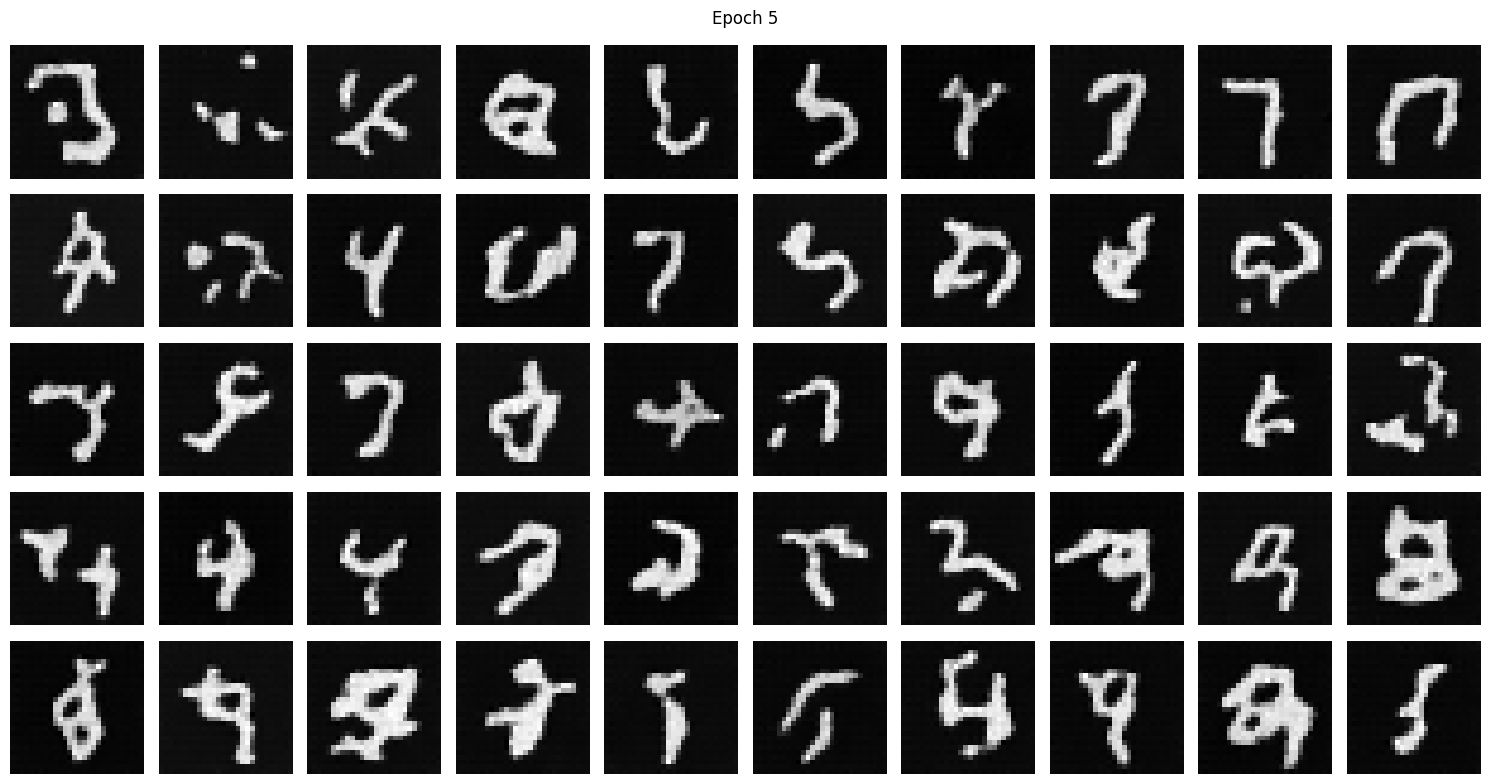

Epoch 6/20, Batch 0/469, Loss: 0.045839
Epoch 6/20, Batch 100/469, Loss: 0.036585
Epoch 6/20, Batch 200/469, Loss: 0.038037
Epoch 6/20, Batch 300/469, Loss: 0.034949
Epoch 6/20, Batch 400/469, Loss: 0.038318
Epoch 6/20 completed. Average Loss: 0.039172
Epoch 7/20, Batch 0/469, Loss: 0.041615
Epoch 7/20, Batch 100/469, Loss: 0.034655
Epoch 7/20, Batch 200/469, Loss: 0.038688
Epoch 7/20, Batch 300/469, Loss: 0.046227
Epoch 7/20, Batch 400/469, Loss: 0.033755
Epoch 7/20 completed. Average Loss: 0.038566
Epoch 8/20, Batch 0/469, Loss: 0.039681
Epoch 8/20, Batch 100/469, Loss: 0.035370
Epoch 8/20, Batch 200/469, Loss: 0.032367
Epoch 8/20, Batch 300/469, Loss: 0.033173
Epoch 8/20, Batch 400/469, Loss: 0.036160
Epoch 8/20 completed. Average Loss: 0.037041
Epoch 9/20, Batch 0/469, Loss: 0.036141
Epoch 9/20, Batch 100/469, Loss: 0.036575
Epoch 9/20, Batch 200/469, Loss: 0.034180
Epoch 9/20, Batch 300/469, Loss: 0.037595
Epoch 9/20, Batch 400/469, Loss: 0.039474
Epoch 9/20 completed. Average Los

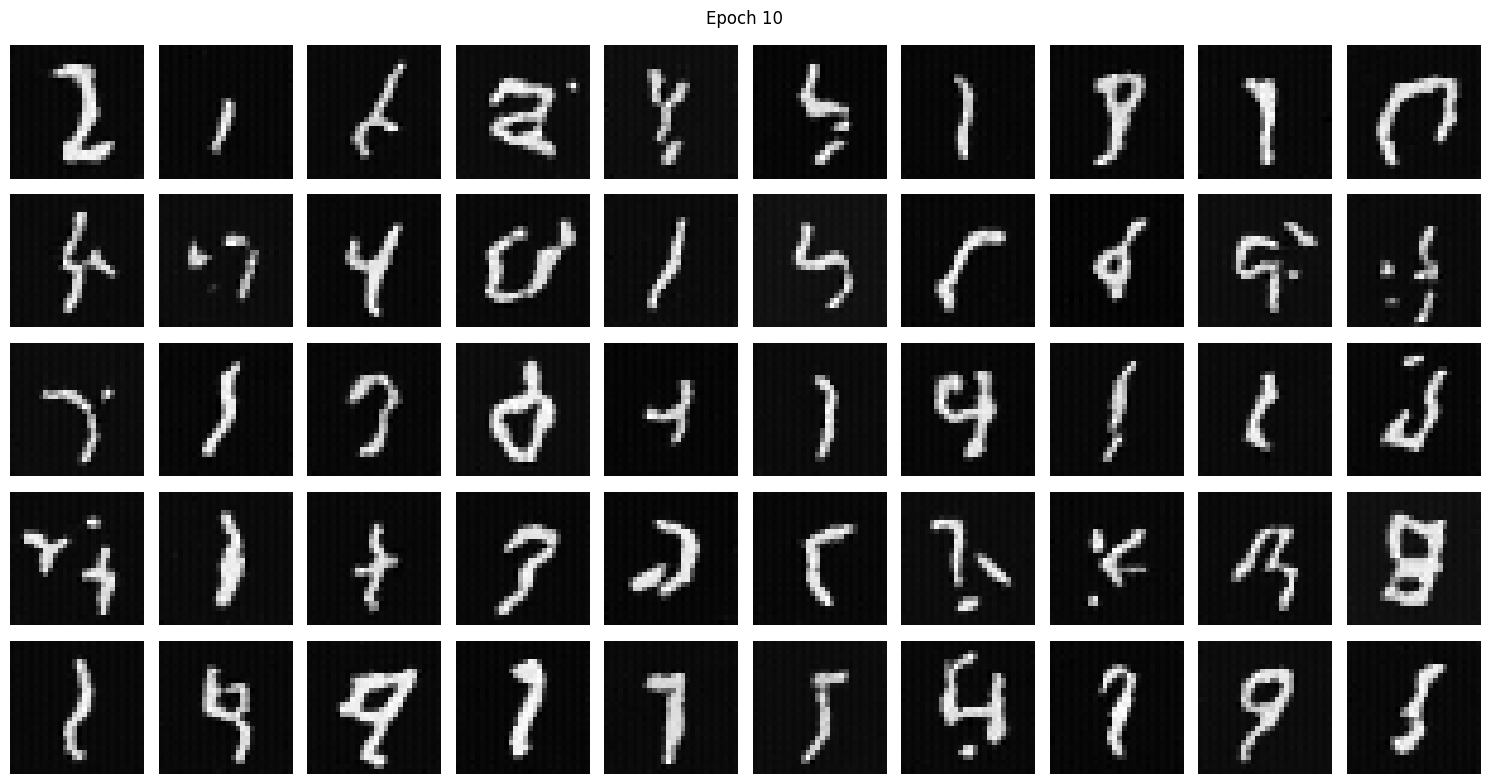

Epoch 11/20, Batch 0/469, Loss: 0.040847
Epoch 11/20, Batch 100/469, Loss: 0.032647
Epoch 11/20, Batch 200/469, Loss: 0.034961
Epoch 11/20, Batch 300/469, Loss: 0.031673
Epoch 11/20, Batch 400/469, Loss: 0.035085
Epoch 11/20 completed. Average Loss: 0.035312
Epoch 12/20, Batch 0/469, Loss: 0.038554
Epoch 12/20, Batch 100/469, Loss: 0.030711
Epoch 12/20, Batch 200/469, Loss: 0.035631
Epoch 12/20, Batch 300/469, Loss: 0.040935
Epoch 12/20, Batch 400/469, Loss: 0.031676
Epoch 12/20 completed. Average Loss: 0.035335
Epoch 13/20, Batch 0/469, Loss: 0.036703
Epoch 13/20, Batch 100/469, Loss: 0.031496
Epoch 13/20, Batch 200/469, Loss: 0.030039
Epoch 13/20, Batch 300/469, Loss: 0.030456
Epoch 13/20, Batch 400/469, Loss: 0.034176
Epoch 13/20 completed. Average Loss: 0.034426
Epoch 14/20, Batch 0/469, Loss: 0.034527
Epoch 14/20, Batch 100/469, Loss: 0.034787
Epoch 14/20, Batch 200/469, Loss: 0.031850
Epoch 14/20, Batch 300/469, Loss: 0.035515
Epoch 14/20, Batch 400/469, Loss: 0.037255
Epoch 14/2

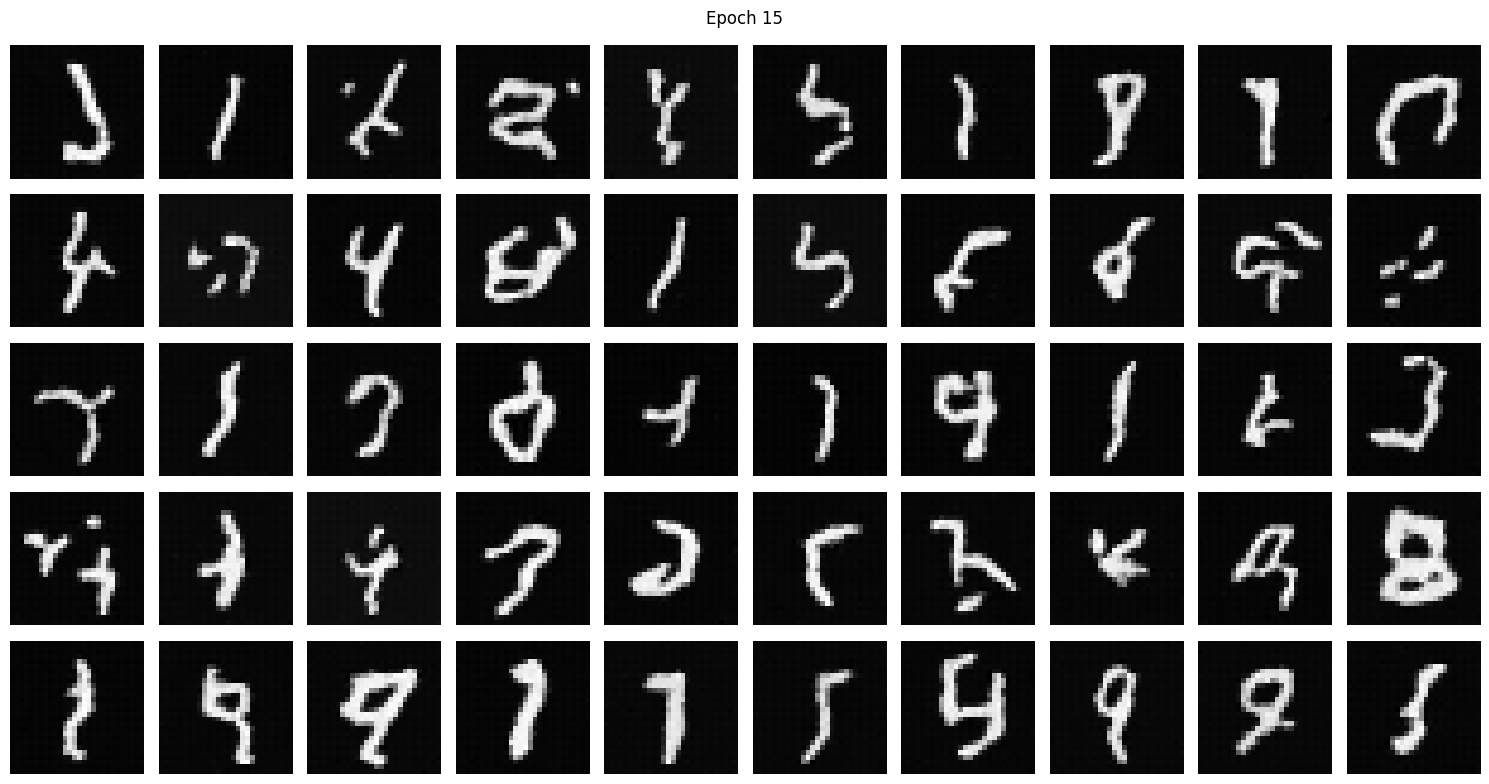

Epoch 16/20, Batch 0/469, Loss: 0.038280
Epoch 16/20, Batch 100/469, Loss: 0.031099
Epoch 16/20, Batch 200/469, Loss: 0.033305
Epoch 16/20, Batch 300/469, Loss: 0.030016
Epoch 16/20, Batch 400/469, Loss: 0.033995
Epoch 16/20 completed. Average Loss: 0.033629
Epoch 17/20, Batch 0/469, Loss: 0.036844
Epoch 17/20, Batch 100/469, Loss: 0.028768
Epoch 17/20, Batch 200/469, Loss: 0.034125
Epoch 17/20, Batch 300/469, Loss: 0.039208
Epoch 17/20, Batch 400/469, Loss: 0.030576
Epoch 17/20 completed. Average Loss: 0.033817
Epoch 18/20, Batch 0/469, Loss: 0.035477
Epoch 18/20, Batch 100/469, Loss: 0.029784
Epoch 18/20, Batch 200/469, Loss: 0.029039
Epoch 18/20, Batch 300/469, Loss: 0.029610
Epoch 18/20, Batch 400/469, Loss: 0.032618
Epoch 18/20 completed. Average Loss: 0.033071
Epoch 19/20, Batch 0/469, Loss: 0.033549
Epoch 19/20, Batch 100/469, Loss: 0.033930
Epoch 19/20, Batch 200/469, Loss: 0.031234
Epoch 19/20, Batch 300/469, Loss: 0.034287
Epoch 19/20, Batch 400/469, Loss: 0.036082
Epoch 19/2

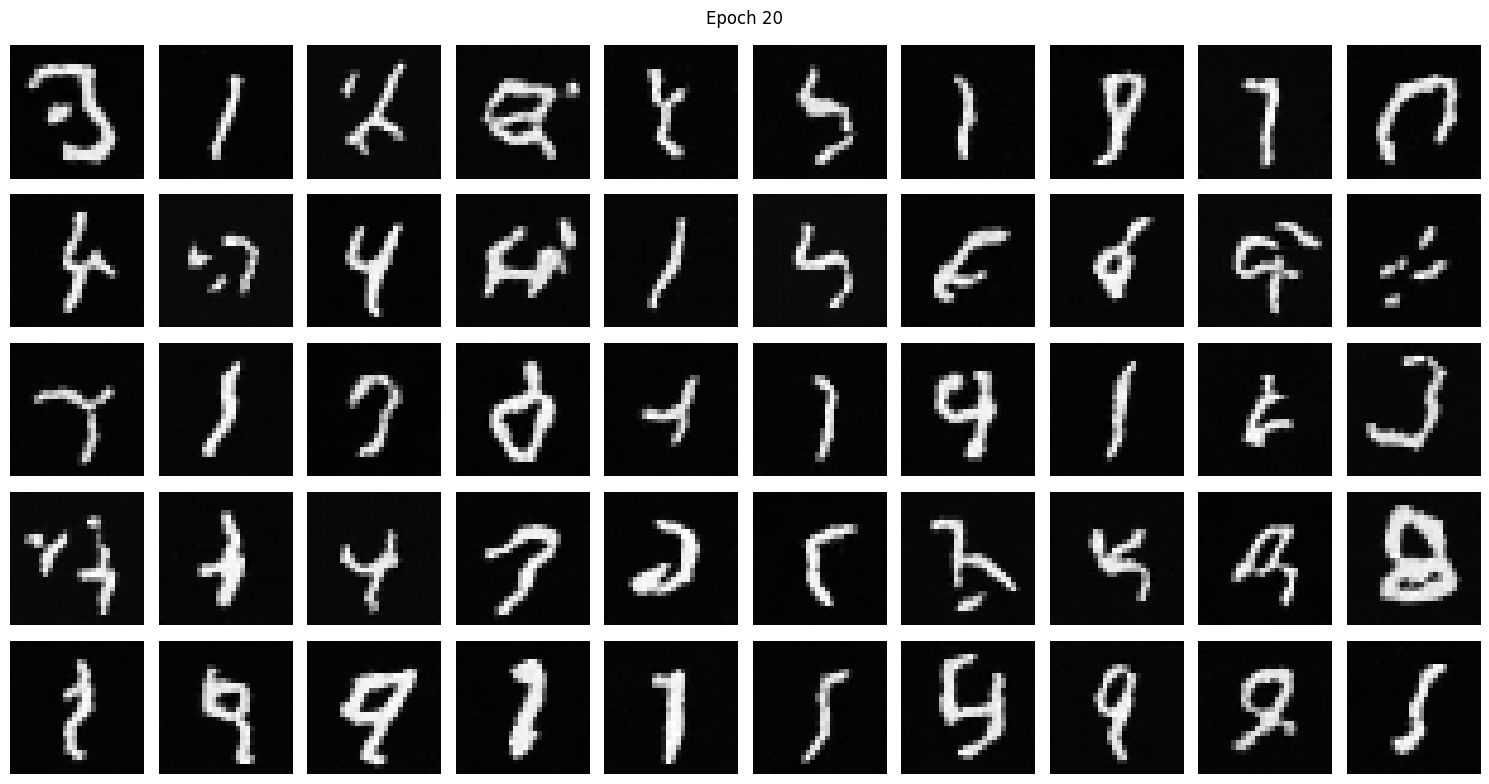

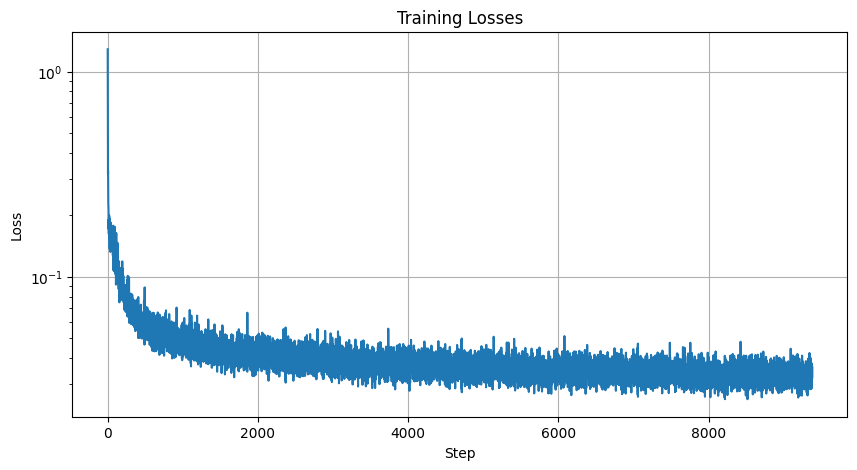

In [56]:

time_ddpm, time_losses = train_time_conditioned_unet()

### Implementing class-conditioned UNet

In [23]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.in_conv = ConvBlock(in_channels, num_hiddens)


        self.down1 = DownBlock(num_hiddens, num_hiddens // 2)
        self.down2 = DownBlock(num_hiddens // 2, num_hiddens // 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens // 4)

        self.fc1_t = FCBlock(1, num_hiddens // 4)
        self.fc2_t = FCBlock(1, num_hiddens // 2)

        self.fc1_c = FCBlock(num_classes, num_hiddens // 4)
        self.fc2_c = FCBlock(num_classes, num_hiddens // 2)
        self.up1 = UpBlock(num_hiddens // 4, num_hiddens // 4)

        self.conv_adjust1 = ConvBlock(3 * num_hiddens // 4, num_hiddens // 2)

        self.up2 = UpBlock(num_hiddens // 2, num_hiddens // 2)
        self.out_conv = nn.Conv2d(3 * num_hiddens // 2, in_channels, kernel_size=3, stride=1, padding=1)

        self.num_classes = num_classes

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:

        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = t.view(-1, 1)
        c_one_hot = F.one_hot(c, num_classes=self.num_classes).float()

        if mask is not None:
            c_one_hot = c_one_hot * mask.view(-1, 1)
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        t1 = self.fc1_t(t)
        c1 = self.fc1_c(c_one_hot)
        t2 = self.fc2_t(t)
        c2 = self.fc2_c(c_one_hot)

        t1 = t1.view(-1, t1.size(1), 1, 1)
        c1 = c1.view(-1, c1.size(1), 1, 1)
        t2 = t2.view(-1, t2.size(1), 1, 1)
        c2 = c2.view(-1, c2.size(1), 1, 1)
        x5 = self.unflatten(x4)
        x5 = c1 * x5 + t1

        x6 = self.up1(x5)
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.conv_adjust1(x6)

        x7 = self.up2(x6)
        x7 = c2 * x7 + t2
        x7 = torch.cat([x7, x1], dim=1)
        out = self.out_conv(x7)
        return out

In [24]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:

    unet.train()
    device = x_0.device
    batch_size = x_0.shape[0]

    t = torch.randint(1, num_ts + 1, (batch_size,), device=device)

    epsilon = torch.randn_like(x_0)

    alpha_bars = ddpm_schedule["alpha_bars"]
    alpha_bars_t = alpha_bars[t - 1].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bars_t) * x_0 + torch.sqrt(1 - alpha_bars_t) * epsilon

    t_norm = (t - 1) / (num_ts - 1)

    mask = torch.ones(batch_size, device=device)
    if p_uncond > 0:
        mask = (torch.rand(batch_size, device=device) >= p_uncond).float()
    epsilon_pred = unet(x_t, c, t_norm, mask)
    loss = F.mse_loss(epsilon_pred, epsilon)

    return loss

In [25]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()

    torch.manual_seed(seed)


    device = next(unet.parameters()).device

    batch_size = c.shape[0]
    x_t = torch.randn(batch_size, 1, img_wh[0], img_wh[1], device=device)

    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]

    num_animation_frames = 5
    animation_step = num_ts // num_animation_frames
    caches = []

    for t in range(num_ts, 0, -1):

        t_norm = torch.ones(batch_size, device=device) * (t - 1) / (num_ts - 1)

        epsilon_cond = unet(x_t, c, t_norm)

        epsilon_uncond = unet(x_t, c, t_norm, mask=torch.zeros(batch_size, device=device))


        epsilon_pred = epsilon_uncond + guidance_scale * (epsilon_cond - epsilon_uncond)

        z = torch.zeros_like(x_t)
        if t > 1:
            z = torch.randn_like(x_t)


        alpha_t = alphas[t - 1]
        alpha_bar_t = alpha_bars[t - 1]
        alpha_bar_prev = alpha_bars[t - 2] if t > 1 else torch.tensor(1.0, device=device)
        beta_t = betas[t - 1]


        eps_coef = beta_t / torch.sqrt(1 - alpha_bar_t)
        mean_coef1 = 1 / torch.sqrt(alpha_t)
        mean_coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)


        mu_theta = mean_coef1 * (x_t - eps_coef * epsilon_pred)


        sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))


        x_t = mu_theta + sigma_t * z


        if t % animation_step == 0 or t == 1:
            caches.append(x_t.clone())


    if len(caches) > 0:
        caches = torch.stack(caches, dim=1)
    else:
        caches = None

    return x_t, caches

In [26]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [33]:
def train_class_conditioned_unet():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

    ddpm = DDPM(model, betas=(1e-4, 0.02), num_ts=300, p_uncond=0.1).to(device)


    optimizer = optim.Adam(ddpm.parameters(), lr=1e-3)

    scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=0.1**(1.0/20)
    )

    num_epochs = 20
    train_losses = []


    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()

        for batch_idx, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            loss = ddpm(data, labels)

            loss.backward()
            optimizer.step()


            epoch_losses.append(loss.item())
            train_losses.append(loss.item())

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.6f}")


        scheduler.step()


        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_epoch_loss:.6f}")

        if (epoch + 1) % 5 == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():

                num_samples_per_class = 4
                num_rows = 4


                all_samples = []


                for i in range(10):

                    class_labels = torch.full((num_samples_per_class,), i, device=device)

                    samples, _ = ddpm.sample(
                        c=class_labels,
                        img_wh=(28, 28),
                        guidance_scale=5.0,
                        seed=epoch * 10 + i
                    )

                    all_samples.append(samples)


                all_samples = torch.cat(all_samples, dim=0)  # [num_samples_per_class * 10, 1, 28, 28]


                all_samples = all_samples.reshape(10, num_samples_per_class, 1, 28, 28)
                all_samples = all_samples.permute(1, 0, 2, 3, 4)  # [num_samples_per_class, 10, 1, 28, 28]
                all_samples = all_samples.reshape(num_samples_per_class * 10, 1, 28, 28)


                fig_rows, fig_cols = num_rows, 10


                plt.figure(figsize=(15, fig_rows * 2))
                for i in range(fig_rows * fig_cols):
                    plt.subplot(fig_rows, fig_cols, i + 1)
                    plt.imshow(all_samples[i, 0].cpu().numpy(), cmap='gray')

                    if i < fig_cols:
                        plt.title(f"{i}")
                    plt.axis('off')

                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.yscale('log')
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return ddpm, train_losses


训练类条件UNet...
Epoch 1/20, Batch 0/469, Loss: 1.080080
Epoch 1/20, Batch 100/469, Loss: 0.082391
Epoch 1/20, Batch 200/469, Loss: 0.063436
Epoch 1/20, Batch 300/469, Loss: 0.055569
Epoch 1/20, Batch 400/469, Loss: 0.051188
Epoch 1/20 completed. Average Loss: 0.080138


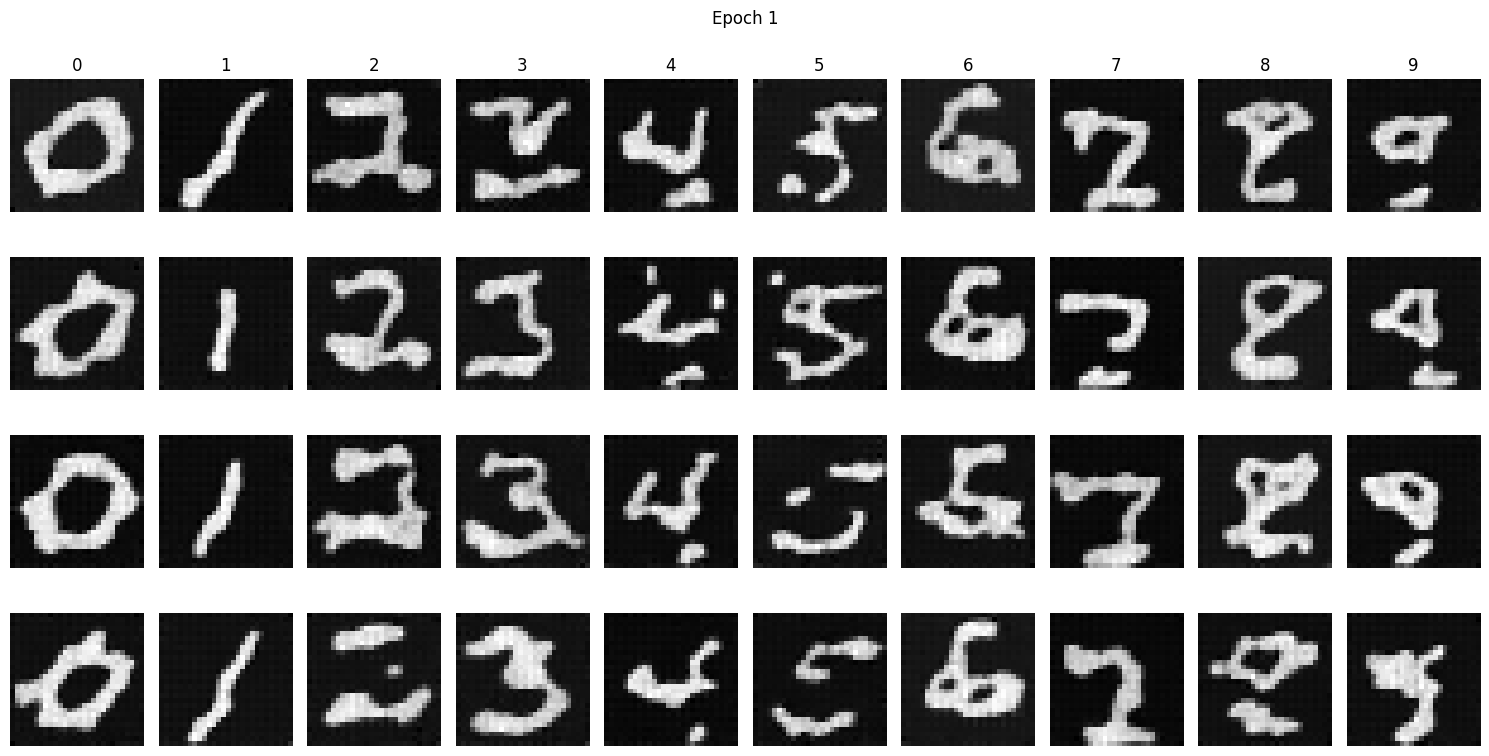

Epoch 2/20, Batch 0/469, Loss: 0.047331
Epoch 2/20, Batch 100/469, Loss: 0.046213
Epoch 2/20, Batch 200/469, Loss: 0.052315
Epoch 2/20, Batch 300/469, Loss: 0.047071
Epoch 2/20, Batch 400/469, Loss: 0.041067
Epoch 2/20 completed. Average Loss: 0.048163
Epoch 3/20, Batch 0/469, Loss: 0.041747
Epoch 3/20, Batch 100/469, Loss: 0.047226
Epoch 3/20, Batch 200/469, Loss: 0.041438
Epoch 3/20, Batch 300/469, Loss: 0.040825
Epoch 3/20, Batch 400/469, Loss: 0.038904
Epoch 3/20 completed. Average Loss: 0.043949
Epoch 4/20, Batch 0/469, Loss: 0.031610
Epoch 4/20, Batch 100/469, Loss: 0.035174
Epoch 4/20, Batch 200/469, Loss: 0.038102
Epoch 4/20, Batch 300/469, Loss: 0.041210
Epoch 4/20, Batch 400/469, Loss: 0.036209
Epoch 4/20 completed. Average Loss: 0.041074
Epoch 5/20, Batch 0/469, Loss: 0.037328
Epoch 5/20, Batch 100/469, Loss: 0.036709
Epoch 5/20, Batch 200/469, Loss: 0.035196
Epoch 5/20, Batch 300/469, Loss: 0.044784
Epoch 5/20, Batch 400/469, Loss: 0.046303
Epoch 5/20 completed. Average Los

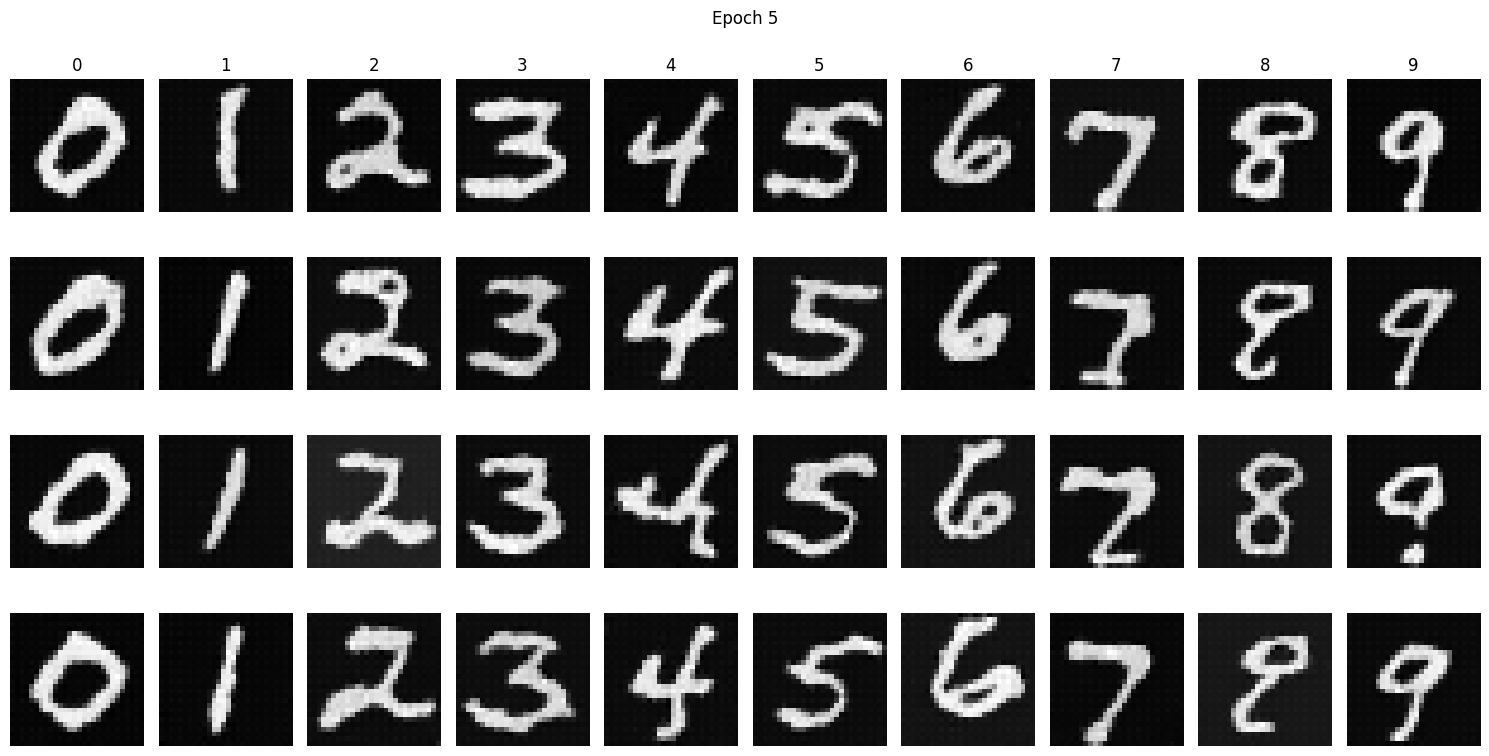

Epoch 6/20, Batch 0/469, Loss: 0.045051
Epoch 6/20, Batch 100/469, Loss: 0.033928
Epoch 6/20, Batch 200/469, Loss: 0.038368
Epoch 6/20, Batch 300/469, Loss: 0.035909
Epoch 6/20, Batch 400/469, Loss: 0.034127
Epoch 6/20 completed. Average Loss: 0.038142
Epoch 7/20, Batch 0/469, Loss: 0.037190
Epoch 7/20, Batch 100/469, Loss: 0.034260
Epoch 7/20, Batch 200/469, Loss: 0.035903
Epoch 7/20, Batch 300/469, Loss: 0.033324
Epoch 7/20, Batch 400/469, Loss: 0.041548
Epoch 7/20 completed. Average Loss: 0.036967
Epoch 8/20, Batch 0/469, Loss: 0.037878
Epoch 8/20, Batch 100/469, Loss: 0.031774
Epoch 8/20, Batch 200/469, Loss: 0.035862
Epoch 8/20, Batch 300/469, Loss: 0.034183
Epoch 8/20, Batch 400/469, Loss: 0.032874
Epoch 8/20 completed. Average Loss: 0.036073
Epoch 9/20, Batch 0/469, Loss: 0.040653
Epoch 9/20, Batch 100/469, Loss: 0.030821
Epoch 9/20, Batch 200/469, Loss: 0.031143
Epoch 9/20, Batch 300/469, Loss: 0.032395
Epoch 9/20, Batch 400/469, Loss: 0.038874
Epoch 9/20 completed. Average Los

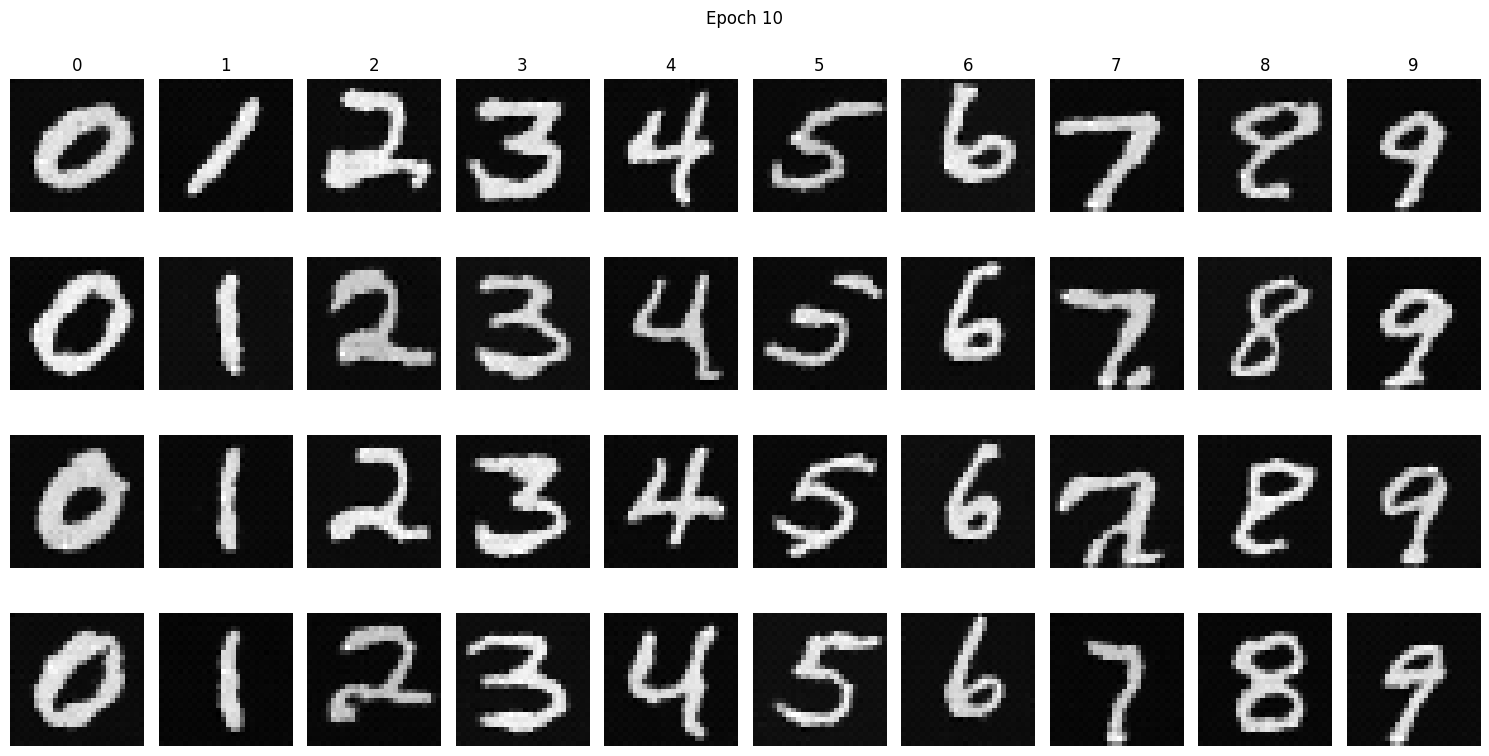

Epoch 11/20, Batch 0/469, Loss: 0.036461
Epoch 11/20, Batch 100/469, Loss: 0.031237
Epoch 11/20, Batch 200/469, Loss: 0.036349
Epoch 11/20, Batch 300/469, Loss: 0.030882
Epoch 11/20, Batch 400/469, Loss: 0.034025
Epoch 11/20 completed. Average Loss: 0.034474
Epoch 12/20, Batch 0/469, Loss: 0.032057
Epoch 12/20, Batch 100/469, Loss: 0.030982
Epoch 12/20, Batch 200/469, Loss: 0.030448
Epoch 12/20, Batch 300/469, Loss: 0.036443
Epoch 12/20, Batch 400/469, Loss: 0.042416
Epoch 12/20 completed. Average Loss: 0.034028
Epoch 13/20, Batch 0/469, Loss: 0.032375
Epoch 13/20, Batch 100/469, Loss: 0.030888
Epoch 13/20, Batch 200/469, Loss: 0.043575
Epoch 13/20, Batch 300/469, Loss: 0.029864
Epoch 13/20, Batch 400/469, Loss: 0.033079
Epoch 13/20 completed. Average Loss: 0.033458
Epoch 14/20, Batch 0/469, Loss: 0.039660
Epoch 14/20, Batch 100/469, Loss: 0.028732
Epoch 14/20, Batch 200/469, Loss: 0.035151
Epoch 14/20, Batch 300/469, Loss: 0.034462
Epoch 14/20, Batch 400/469, Loss: 0.034154
Epoch 14/2

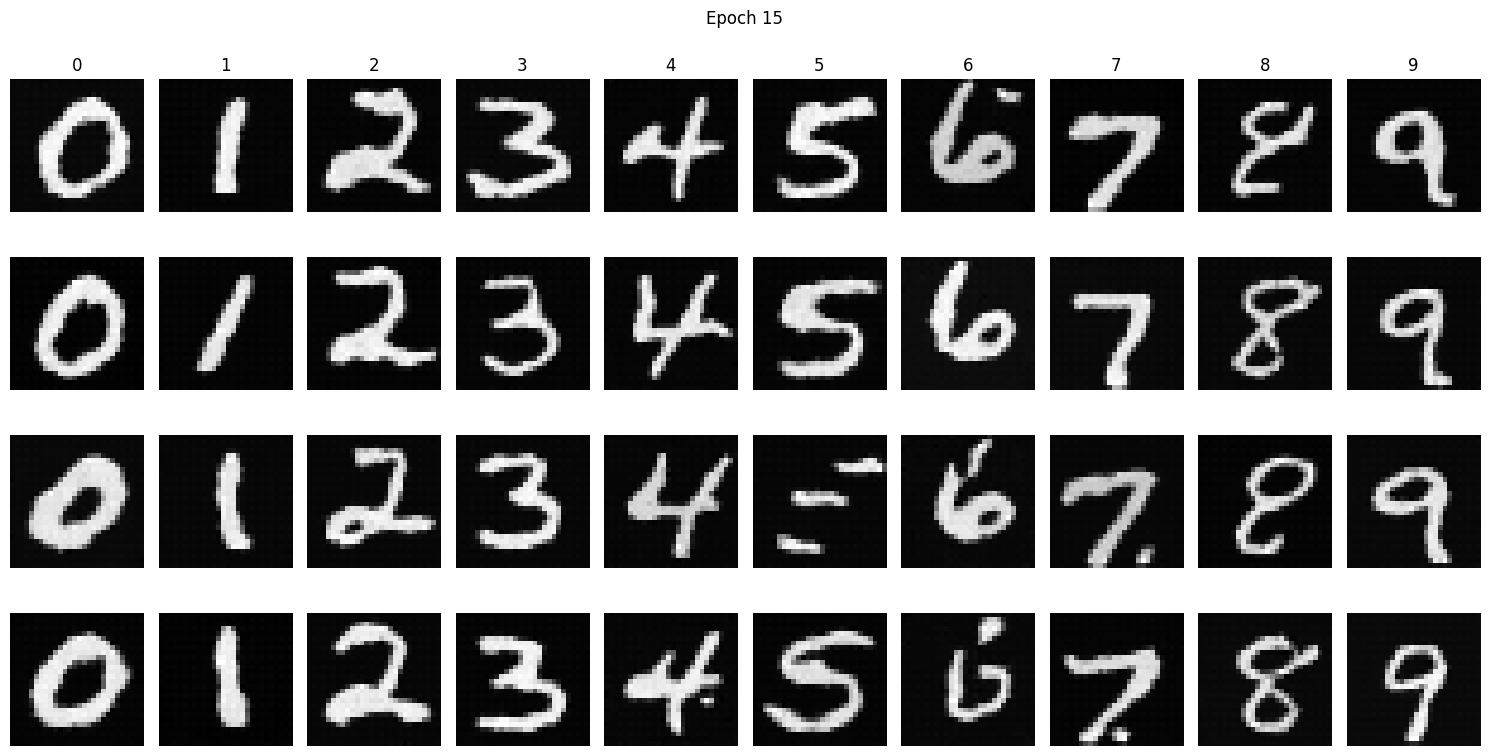

Epoch 16/20, Batch 0/469, Loss: 0.033545
Epoch 16/20, Batch 100/469, Loss: 0.031604
Epoch 16/20, Batch 200/469, Loss: 0.034289
Epoch 16/20, Batch 300/469, Loss: 0.035195
Epoch 16/20, Batch 400/469, Loss: 0.033732
Epoch 16/20 completed. Average Loss: 0.032832
Epoch 17/20, Batch 0/469, Loss: 0.036568
Epoch 17/20, Batch 100/469, Loss: 0.030201
Epoch 17/20, Batch 200/469, Loss: 0.031888
Epoch 17/20, Batch 300/469, Loss: 0.028919
Epoch 17/20, Batch 400/469, Loss: 0.030227
Epoch 17/20 completed. Average Loss: 0.032215
Epoch 18/20, Batch 0/469, Loss: 0.028454
Epoch 18/20, Batch 100/469, Loss: 0.028523
Epoch 18/20, Batch 200/469, Loss: 0.027118
Epoch 18/20, Batch 300/469, Loss: 0.030953
Epoch 18/20, Batch 400/469, Loss: 0.032117
Epoch 18/20 completed. Average Loss: 0.032009
Epoch 19/20, Batch 0/469, Loss: 0.028144
Epoch 19/20, Batch 100/469, Loss: 0.026790
Epoch 19/20, Batch 200/469, Loss: 0.026895
Epoch 19/20, Batch 300/469, Loss: 0.030262
Epoch 19/20, Batch 400/469, Loss: 0.037560
Epoch 19/2

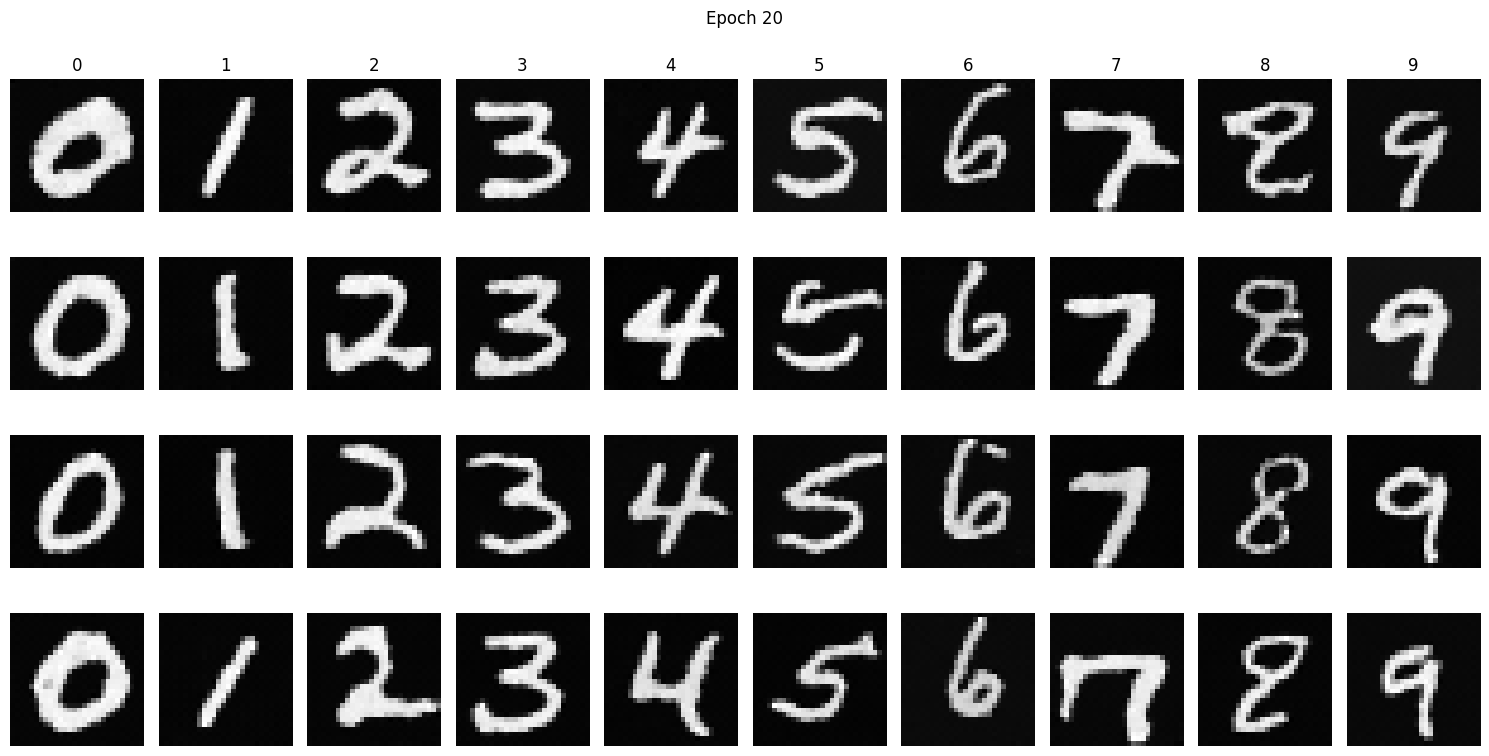

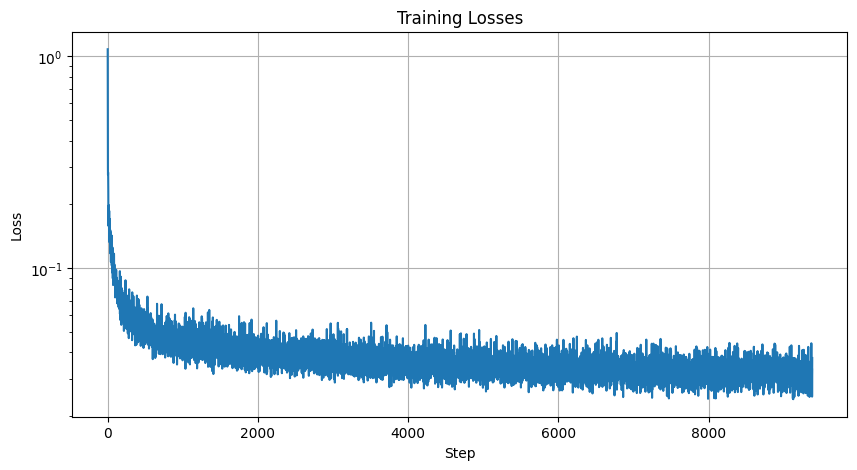

In [34]:

class_ddpm, class_losses = train_class_conditioned_unet()